### 1.1 Import Libraries

In [26]:
from sklearn.metrics import make_scorer, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn import preprocessing
import matplotlib.pylab as pylab
import matplotlib.pyplot as plt
from pandas import get_dummies
import matplotlib as mpl
#import xgboost as xgb
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib
import warnings
import sklearn
import scipy
import numpy
import json
import sys
import csv
import os

### 2.1 Code Readability

In [4]:
sns.set(style='white', context='notebook', palette='deep')
pylab.rcParams['figure.figsize'] = 12,8
warnings.filterwarnings('ignore')
mpl.style.use('ggplot')
sns.set_style('white')
%matplotlib inline

### 3.1 Data Collection

In [5]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

In [6]:
type(df_train)

pandas.core.frame.DataFrame

In [7]:
type(df_test)

pandas.core.frame.DataFrame

### 3.2 Data Visualization

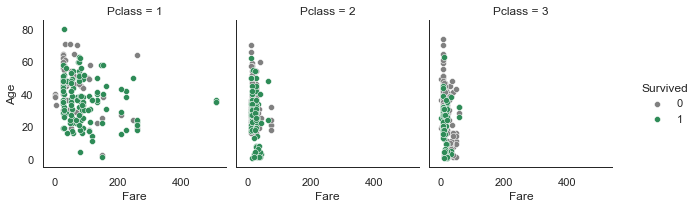

In [8]:
g = sns.FacetGrid(df_train, hue="Survived", col="Pclass", margin_titles=True,
                  palette={1:"seagreen", 0:"gray"})
g=g.map(plt.scatter, "Fare", "Age",edgecolor="w").add_legend();

### 3.3 Data Preprocessing

In [12]:
print(df_train.shape)

(891, 12)


In [13]:
df_train.size

10692

In [14]:
df_train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

### 3.4 Data Cleaning


In [9]:
def simplify_ages(df):
    df.Age = df.Age.fillna(-0.5)
    bins = (-1, 0, 5, 12, 18, 25, 35, 60, 120)
    group_names = ['Unknown', 'Baby', 'Child', 'Teenager', 'Student', 'Young Adult', 'Adult', 'Senior']
    categories = pd.cut(df.Age, bins, labels=group_names)
    df.Age = categories
    return df

def simplify_cabins(df):
    df.Cabin = df.Cabin.fillna('N')
    df.Cabin = df.Cabin.apply(lambda x: x[0])
    return df

def simplify_fares(df):
    df.Fare = df.Fare.fillna(-0.5)
    bins = (-1, 0, 8, 15, 31, 1000)
    group_names = ['Unknown', '1_quartile', '2_quartile', '3_quartile', '4_quartile']
    categories = pd.cut(df.Fare, bins, labels=group_names)
    df.Fare = categories
    return df

def format_name(df):
    df['Lname'] = df.Name.apply(lambda x: x.split(' ')[0])
    df['NamePrefix'] = df.Name.apply(lambda x: x.split(' ')[1])
    return df    
    
def drop_features(df):
    return df.drop(['Ticket', 'Name', 'Embarked'], axis=1)

def transform_features(df):
    df = simplify_ages(df)
    df = simplify_cabins(df)
    df = simplify_fares(df)
    df = format_name(df)
    df = drop_features(df)
    return df

df_train = transform_features(df_train)
df_test = transform_features(df_test)
df_train.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Lname,NamePrefix
0,1,0,3,male,Student,1,0,1_quartile,N,"Braund,",Mr.
1,2,1,1,female,Adult,1,0,4_quartile,C,"Cumings,",Mrs.
2,3,1,3,female,Young Adult,0,0,1_quartile,N,"Heikkinen,",Miss.
3,4,1,1,female,Young Adult,1,0,4_quartile,C,"Futrelle,",Mrs.
4,5,0,3,male,Young Adult,0,0,2_quartile,N,"Allen,",Mr.


In [10]:
def encode_features(df_train, df_test):
    features = ['Fare', 'Cabin', 'Age', 'Sex', 'Lname', 'NamePrefix']
    df_combined = pd.concat([df_train[features], df_test[features]])
    
    for feature in features:
        le = preprocessing.LabelEncoder()
        le = le.fit(df_combined[feature])
        df_train[feature] = le.transform(df_train[feature])
        df_test[feature] = le.transform(df_test[feature])
    return df_train, df_test


### 4.1 Prepare Feature

In [11]:
df_train, df_test = encode_features(df_train, df_test)
df_train.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Lname,NamePrefix
0,1,0,3,1,4,1,0,0,7,100,19
1,2,1,1,0,0,1,0,3,2,182,20
2,3,1,3,0,7,0,0,0,7,329,16
3,4,1,1,0,7,1,0,3,2,267,20
4,5,0,3,1,7,0,0,1,7,15,19


### 4.2 Overfit or Underfit

In [12]:
x_all = df_train.drop(['Survived', 'PassengerId'], axis=1)
y_all = df_train['Survived']

In [13]:
num_test = 0.3
X_train, X_test, y_train, y_test = train_test_split(x_all, y_all, test_size=num_test, random_state=100)

### 4.3 Accuracy

In [14]:
result=None

### 4.4 Random Forest Classifier

In [15]:
rfc = RandomForestClassifier()

# Choose some parameter combinations to try
parameters = {'n_estimators': [4, 6, 9], 
              'max_features': ['log2', 'sqrt','auto'], 
              'criterion': ['entropy', 'gini'],
              'max_depth': [2, 3, 5, 10], 
              'min_samples_split': [2, 3, 5],
              'min_samples_leaf': [1,5,8]
             }

# Type of scoring used to compare parameter combinations
acc_scorer = make_scorer(accuracy_score)

# Run the grid search
grid_obj = GridSearchCV(rfc, parameters, scoring=acc_scorer)
grid_obj = grid_obj.fit(X_train, y_train)

# Set the clf to the best combination of parameters
rfc = grid_obj.best_estimator_

# Fit the best algorithm to the data. 
rfc.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
                       max_depth=3, max_features='log2', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=9,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [16]:
rfc_prediction = rfc.predict(X_test)
rfc_score=accuracy_score(y_test, rfc_prediction)
print(rfc_score)

0.7947761194029851


### 4.5 Decision Tree Regressor

In [19]:
from sklearn.tree import DecisionTreeRegressor

# Define model. Specify a number for random_state to ensure same results each run
dt = DecisionTreeRegressor(random_state=1)

In [20]:
dt.fit(X_train, y_train)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=1, splitter='best')

In [21]:
dt_prediction = dt.predict(X_test)
dt_score=accuracy_score(y_test, dt_prediction)
print(dt_score)


0.7835820895522388


In [22]:
X_train = df_train.drop("Survived",axis=1)
y_train = df_train["Survived"]

In [23]:
X_train = X_train.drop("PassengerId",axis=1)
X_test  = df_test.drop("PassengerId",axis=1)

In [27]:
Y_pred = dt.predict(X_test)

In [28]:
submission = pd.DataFrame({
        "PassengerId": df_test["PassengerId"],
        "Survived": Y_pred
    })
submission.to_csv('submission.csv', index=False)